In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Gets the optical flow [<dx,dy>] from two frames
def getOpticalFlow(imPrev, imNew):
    flow = cv2.calcOpticalFlowFarneback(imPrev, imNew, flow=None, pyr_scale=.5, levels=3, winsize=9, iterations=1, poly_n=3, poly_sigma=1.1, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    return flow

In [4]:
# Util functions to plot two images side by side
def show2images(im1, im2, title1="Image 1", title2="image 2"):
    plt.subplot(1,2,1),plt.imshow(im1, cmap="gray"),plt.title(title1),plt.xticks([]),plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(im2, cmap="gray"),plt.title(title2),plt.xticks([]),plt.yticks([])
    plt.show()

Testing capturing frames from videos via CV2

In [32]:
SOURCE = "sample.mp4"
cap = cv2.VideoCapture(SOURCE)
ret1, frame1_original = cap.read()
ret2, frame2_original = cap.read()
cap.release()

print ret1
print ret2


import os

print os.getcwd()

True
True
/Users/kaveenherath/Documents/github/project-okulo


We are standardizing the images so they are all grayscaled and have the same width and height

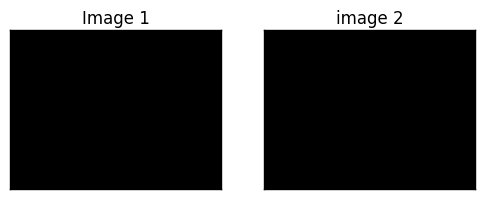

In [33]:
FIXED_WIDTH = 160
FIXED_HEIGHT = 120

frame1_gray = cv2.cvtColor(frame1_original,cv2.COLOR_BGR2GRAY)
frame2_gray = cv2.cvtColor(frame2_original,cv2.COLOR_BGR2GRAY)

frame1_gray_resized = cv2.resize(frame1_gray, (FIXED_WIDTH, FIXED_HEIGHT))
frame2_gray_resized = cv2.resize(frame1_gray, (FIXED_WIDTH, FIXED_HEIGHT))

show2images(frame1_gray_resized, frame2_gray_resized)

Calculate the optical flow of the two standardized images

In [34]:
flow = getOpticalFlow(frame1_gray_resized, frame2_gray_resized)

In [41]:
# Compute the Histogram of Optical Flow (HoF) from the given optica flow

from scipy import sqrt, pi, arctan2, cos, sin
from scipy.ndimage import uniform_filter
def hof(flow, orientations=9, pixels_per_cell=(10, 10),
        cells_per_block=(4, 3), visualise=False, normalise=False, motion_threshold=1.):

    """Extract Histogram of Optical Flow (HOF) for a given image.
    Key difference between this and HOG is that flow is MxNx2 instead of MxN
    Compute a Histogram of Optical Flow (HOF) by
        1. (optional) global image normalisation
        2. computing the dense optical flow
        3. computing flow histograms
        4. normalising across blocks
        5. flattening into a feature vector
    Parameters
    ----------
    Flow : (M, N) ndarray
        Input image (x and y flow images).
    orientations : int
        Number of orientation bins.
    pixels_per_cell : 2 tuple (int, int)
        Size (in pixels) of a cell.
    cells_per_block  : 2 tuple (int,int)
        Number of cells in each block.
    visualise : bool, optional
        Also return an image of the hof.
    normalise : bool, optional
        Apply power law compression to normalise the image before
        processing.
    static_threshold : threshold for no motion
    Returns
    -------
    newarr : ndarray
        hof for the image as a 1D (flattened) array.
    hof_image : ndarray (if visualise=True)
        A visualisation of the hof image.
    References
    ----------
    * http://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
    * Dalal, N and Triggs, B, Histograms of Oriented Gradients for
      Human Detection, IEEE Computer Society Conference on Computer
      Vision and Pattern Recognition 2005 San Diego, CA, USA
    """
    flow = np.atleast_2d(flow)

    """ 
    -1-
    The first stage applies an optional global image normalisation
    equalisation that is designed to reduce the influence of illumination
    effects. In practice we use gamma (power law) compression, either
    computing the square root or the log of each colour channel.
    Image texture strength is typically proportional to the local surface
    illumination so this compression helps to reduce the effects of local
    shadowing and illumination variations.
    """

    if flow.ndim < 3:
        raise ValueError("Requires dense flow in both directions")

    if normalise:
        flow = sqrt(flow)

    """ 
    -2-
    The second stage computes first order image gradients. These capture
    contour, silhouette and some texture information, while providing
    further resistance to illumination variations. The locally dominant
    colour channel is used, which provides colour invariance to a large
    extent. Variant methods may also include second order image derivatives,
    which act as primitive bar detectors - a useful feature for capturing,
    e.g. bar like structures in bicycles and limbs in humans.
    """

    if flow.dtype.kind == 'u':
        # convert uint image to float
        # to avoid problems with subtracting unsigned numbers in np.diff()
        flow = flow.astype('float')

    gx = np.zeros(flow.shape[:2])
    gy = np.zeros(flow.shape[:2])
    # gx[:, :-1] = np.diff(flow[:,:,1], n=1, axis=1)
    # gy[:-1, :] = np.diff(flow[:,:,0], n=1, axis=0)

    gx = flow[:,:,1]
    gy = flow[:,:,0]



    """ 
    -3-
    The third stage aims to produce an encoding that is sensitive to
    local image content while remaining resistant to small changes in
    pose or appearance. The adopted method pools gradient orientation
    information locally in the same way as the SIFT [Lowe 2004]
    feature. The image window is divided into small spatial regions,
    called "cells". For each cell we accumulate a local 1-D histogram
    of gradient or edge orientations over all the pixels in the
    cell. This combined cell-level 1-D histogram forms the basic
    "orientation histogram" representation. Each orientation histogram
    divides the gradient angle range into a fixed number of
    predetermined bins. The gradient magnitudes of the pixels in the
    cell are used to vote into the orientation histogram.
    """

    magnitude = sqrt(gx**2 + gy**2)
    orientation = arctan2(gy, gx) * (180 / pi) % 180

    sy, sx = flow.shape[:2]
    cx, cy = pixels_per_cell
    bx, by = cells_per_block

    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y

    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsy, n_cellsx, orientations))
    subsample = np.index_exp[cy / 2:cy * n_cellsy:cy, cx / 2:cx * n_cellsx:cx]
    for i in range(orientations-1):
        #create new integral image for this orientation
        # isolate orientations in this range

        temp_ori = np.where(orientation < 180 / orientations * (i + 1),
                            orientation, -1)
        temp_ori = np.where(orientation >= 180 / orientations * i,
                            temp_ori, -1)
        # select magnitudes for those orientations
        cond2 = (temp_ori > -1) * (magnitude > motion_threshold)
        temp_mag = np.where(cond2, magnitude, 0)

        temp_filt = uniform_filter(temp_mag, size=(cy, cx))
        orientation_histogram[:, :, i] = temp_filt[subsample]

    ''' Calculate the no-motion bin '''
    temp_mag = np.where(magnitude <= motion_threshold, magnitude, 0)

    temp_filt = uniform_filter(temp_mag, size=(cy, cx))
    orientation_histogram[:, :, -1] = temp_filt[subsample]

    # now for each cell, compute the histogram
    hof_image = None

    if visualise:
        from skimage import draw

        radius = min(cx, cy) // 2 - 1
        hof_image = np.zeros((sy, sx), dtype=float)
        for x in range(n_cellsx):
            for y in range(n_cellsy):
                for o in range(orientations-1):
                    centre = tuple([y * cy + cy // 2, x * cx + cx // 2])
                    dx = int(radius * cos(float(o) / orientations * np.pi))
                    dy = int(radius * sin(float(o) / orientations * np.pi))
                    rr, cc = draw.bresenham(centre[0] - dy, centre[1] - dx,
                                            centre[0] + dy, centre[1] + dx)
                    hof_image[rr, cc] += orientation_histogram[y, x, o]

    """
    The fourth stage computes normalisation, which takes local groups of
    cells and contrast normalises their overall responses before passing
    to next stage. Normalisation introduces better invariance to illumination,
    shadowing, and edge contrast. It is performed by accumulating a measure
    of local histogram "energy" over local groups of cells that we call
    "blocks". The result is used to normalise each cell in the block.
    Typically each individual cell is shared between several blocks, but
    its normalisations are block dependent and thus different. The cell
    thus appears several times in the final output vector with different
    normalisations. This may seem redundant but it improves the performance.
    We refer to the normalised block descriptors as Histogram of Oriented
    Gradient (hog) descriptors.
    """

    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    normalised_blocks = np.zeros((n_blocksy, n_blocksx,
                                  by, bx, orientations))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[y:y+by, x:x+bx, :]
            eps = 1e-5
            normalised_blocks[y, x, :] = block / sqrt(block.sum()**2 + eps)

    """
    The final step collects the hof descriptors from all blocks of a dense
    overlapping grid of blocks covering the detection window into a combined
    feature vector for use in the window classifier.
    """

    if visualise:
        return normalised_blocks.ravel(), hof_image
    else:
        return normalised_blocks.ravel()

In [42]:
hof_result = hof(flow, pixels_per_cell=(20,20), cells_per_block=(5,5))
print hof_result.shape
print hof_result

(1800,)
[ 0.  0.  0. ...,  0.  0.  0.]


In [43]:
from sklearn import svm
import os

# Collect the file path of all the running and walking videos, we will only be using these 2 classes
RUN_DIR = "hof/run/"
RUN_FILES = os.listdir(RUN_DIR)
RUN_FILES = [RUN_DIR + f for f in RUN_FILES]
WALK_DIR = "hof/walk/"
WALK_FILES = os.listdir(WALK_DIR)
WALK_FILES = [WALK_DIR + f for f in WALK_FILES]

# Use equal number of data from each class
nc = min(len(RUN_FILES), len(WALK_FILES))
print "nc:", nc
RUN_FILES = RUN_FILES[0:nc]
WALK_FILES = WALK_FILES[0:nc]

RATIO = 0.9
offset = int(np.floor(nc*RATIO))
print "offset:", offset

# Split test and training at a ratio of 1:9
train_files = RUN_FILES[0:offset] + WALK_FILES[0:offset]
test_files = RUN_FILES[offset:nc] + WALK_FILES[offset:nc]

# Put the labels in vectors
train_labels = np.zeros(offset*2, int)
train_labels[0:offset] = 1 #RUN=1
train_labels[offset:offset*2] = 2 #WALK=2

test_len = nc-offset
test_labels = np.zeros(test_len*2, int)
test_labels[0:test_len] = 1 #RUN=1
test_labels[test_len:test_len*2] = 2 #WALK=2

print "train files:", len(train_files)
print "train labels:", len(train_labels)
print "test files:", len(test_files)
print "test labels:", len(test_labels)

nc: 232
offset: 208
train files: 416
train labels: 416
test files: 48
test labels: 48


In [44]:
# Standardize the frames to gray-scale and equal dimensions

FIXED_WIDTH = 160
FIXED_HEIGHT = 120
def normalizeFrame(frame_original):
    frame_gray = cv2.cvtColor(frame_original,cv2.COLOR_BGR2GRAY)
    frame_gray_resized = cv2.resize(frame_gray, (FIXED_WIDTH, FIXED_HEIGHT))
    return frame_gray_resized

In [45]:
# get the Histogram of Optical Flow from two images
def getHoF(frame1, frame2):
    flow = getOpticalFlow(frame1, frame2)
    return hof(flow, pixels_per_cell=(20,20), cells_per_block=(5,5))

In [46]:
# get the Histogram of Optical Flows of a video grouped sequentially in a 1D array
def getSequentialHoF(video_path):
    hofs = []
    cap = cv2.VideoCapture(video_path)
    ret1, frame1 = cap.read()
    frame1 = normalizeFrame(frame1)
    while(cap.isOpened()):
        ret2, frame2 = cap.read()
        if ret2 == True:
            frame2 = normalizeFrame(frame2)
            hof_array = getHoF(frame1, frame2)
            hofs = np.concatenate((hofs, hof_array),axis=0)
#             show2images(frame1, frame2)
            frame1 = frame2
        else:
            break
    return hofs

Construct the training set and test set, which are arrays of sequential HoF for each video

In [47]:
train = [getSequentialHoF(p) for p in train_files]
test = [getSequentialHoF(p) for p in test_files]

### The problem is, the rows have varying lengths

In [48]:
print len(test[1])
print len(test[2])

131400
86400


We find the row with the largest length in training set and testing set

In [49]:
max_width = max(np.array([len(i) for i in train]).max(),np.array([len(i) for i in test]).max())

This method pads each row of the 2D array, with 0, to a specified width.

In [50]:
def numpy_fillna(data, width):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(width) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out

We are changing every row length to the maximum row length in testing and training set

In [51]:
train_pad = numpy_fillna(np.array(train), max_width)
test_pad = numpy_fillna(np.array(test), max_width)

Create an SVM model

In [181]:
from sklearn import svm

clf = svm.SVC()
clf.fit(train_pad, train_labels)
predict = clf.predict(test_pad)

Get the accuracy of the SVM model

In [182]:
from sklearn import metrics
metrics.accuracy_score(predict, test_labels)

0.60416666666666663

Decision Tree

In [184]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(train_pad, train_labels)
predict = tree_clf.predict(test_pad)
metrics.accuracy_score(predict, test_labels)

0.54166666666666663

Random Forest

In [186]:
from sklearn import ensemble
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(train_pad, train_labels)
predict = rf_clf.predict(test_pad)
metrics.accuracy_score(predict, test_labels)

0.625

Logistic Regression

In [188]:
from sklearn import linear_model
lr_clf = linear_model.LogisticRegression()
lr_clf.fit(train_pad, train_labels)
predict = lr_clf.predict(test_pad)
metrics.accuracy_score(predict, test_labels)

0.5625

In [55]:
#KNN DTW GITHUB METHODS

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxint * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in xrange(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in xrange(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in xrange(1, M):
            for j in xrange(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
          
            
            for i in xrange(0, x_s[0] - 1):
                for j in xrange(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
           
        
            for i in xrange(0, x_s[0]):
                for j in xrange(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

In [59]:
#KNN code using dtw n = 1
print(train)
t = KnnDtw(n_neighbors=1)
t.fit(train, train_labels)
label, proba = t.predict(test)
metrics.accuracy_score(label, test_labels)


[array([ 0.00233737,  0.0009237 ,  0.0014669 , ...,  0.        ,
        0.        ,  0.01265291]), array([ 0.        ,  0.        ,  0.        , ...,  0.03793614,
        0.        ,  0.47327111]), array([ 0.        ,  0.        ,  0.        , ...,  0.03455082,
        0.02059288,  0.4210129 ]), array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.43743062]), array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.10473578]), array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.07642964]), array([ 0.00121717,  0.00123289,  0.00666754, ...,  0.        ,
        0.        ,  0.21328463]), array([  0.00000000e+00,   1.41414679e-02,   2.98593448e-02, ...,
         0.00000000e+00,   3.39691726e-18,   1.03740083e-01]), array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.00495456]), array([ 0.00108491,  0.00014608,  0.        , ...,  0.        ,
        0.    

TypeError: list indices must be integers, not tuple